In [1]:
import sys
sys.path.append("../")
sys.path.append("../../../../BayesFlow")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
from scipy.stats import beta, expon

from models import RandomWalkPoissonModel
from experiments import NeuralCoalMiningExperiment, BayesLoopCoalMiningExperiment
from data import coal_mining_data

2023-06-14 15:55:22.724025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 15:55:25.541388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-06-14 15:55:25.541530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
# Get rid of annoying tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Neural Experiment

In [3]:
model = RandomWalkPoissonModel()

INFO:root:Performing 2 pilot runs with the poisson_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [4]:
neural_experiment = NeuralCoalMiningExperiment(model)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [5]:
history = neural_experiment.run(
    epochs=1, 
    iterations_per_epoch=1000, 
    batch_size=32
)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

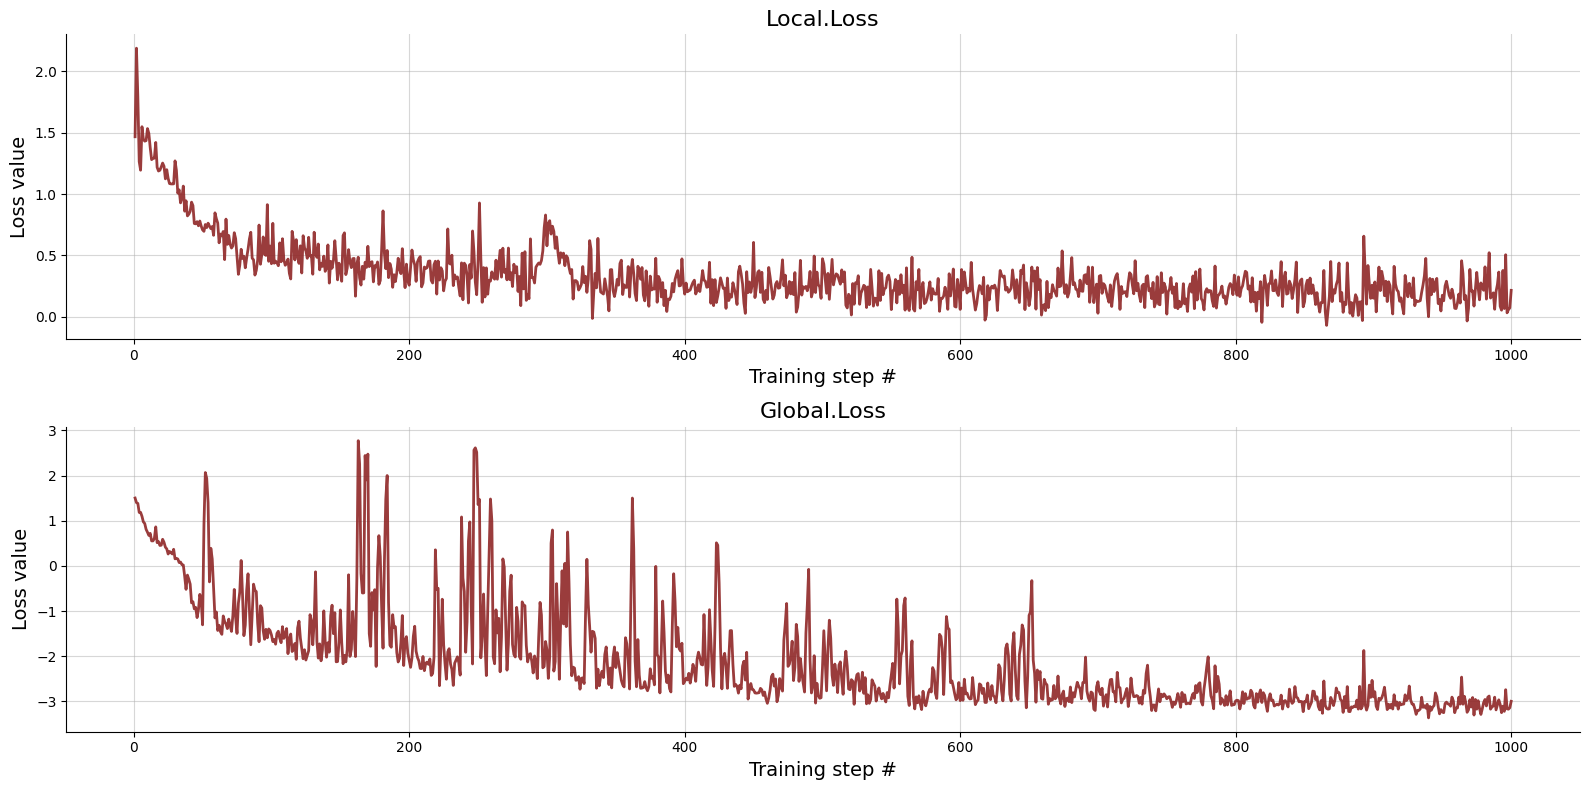

In [6]:
h = beef.diagnostics.plot_losses(neural_experiment.trainer.loss_history.get_plottable())

# Bayesloop Experiment

In [7]:
bayesloop_experiment = BayesLoopCoalMiningExperiment()

+ Created new study.
  --> Hyper-study
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']


In [ ]:
bl_post_means, bl_post_stds = bayesloop_experiment.run(coal_mining_data, filtering=False)

+ Successfully imported array.
+ Set hyper-prior(s): ['25*(1 - x)**24']
+ Started new fit.
    + 4000 analyses to run.


  0%|          | 0/4000 [00:00<?, ?it/s]

# Evaluation

In [32]:
%%time
posterior_samples = neural_experiment.amortizer.sample(
    np.log1p(coal_mining_data["disasters"][None, :, None]), 4000
)

CPU times: user 118 ms, sys: 28.6 ms, total: 146 ms
Wall time: 144 ms


In [33]:
# Un-standardize parameters via prior mean and prior std
local_samples = posterior_samples["local_samples"] * expon.std(scale=1) + expon.mean(scale=1)
post_mean = local_samples.mean(axis=0)
post_std = local_samples.std(axis=0)

In [34]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

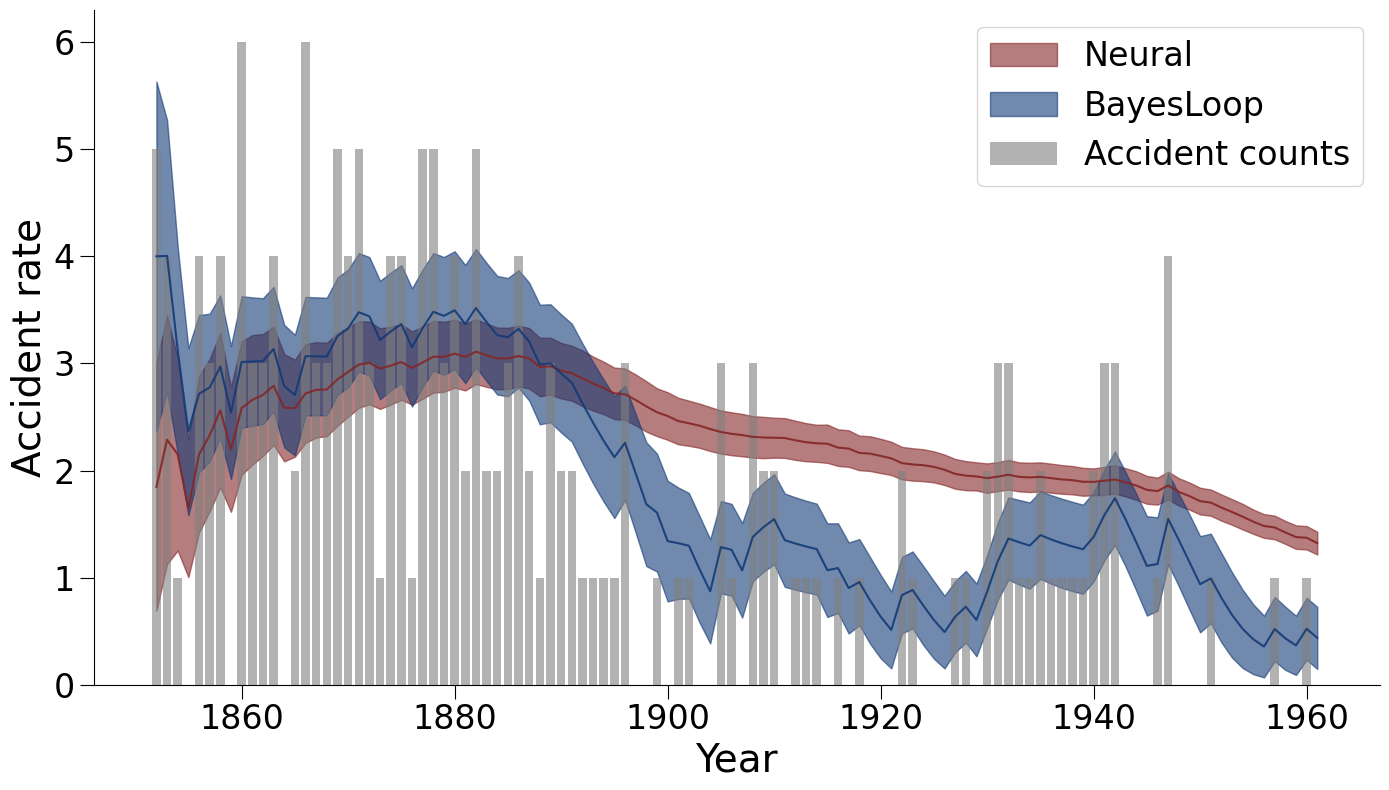

In [35]:
time = coal_mining_data["year"]
plt.figure(figsize=(14, 8))
plt.plot(time, post_mean, alpha=0.9, color=NEURAL_COLOR)
plt.fill_between(
    time,
    post_mean + post_std,
    post_mean - post_std,
    alpha=0.6,
    label="Neural",
    edgecolor="none",
    color=NEURAL_COLOR
)

plt.plot(time, bl_post_means, alpha=0.9, color=COMPARISON_COLOR)
plt.fill_between(
    time,
    bl_post_means + bl_post_stds,
    bl_post_means - bl_post_stds,
    alpha=0.6,
    label='BayesLoop',
    edgecolor="none",
    color=COMPARISON_COLOR
)

plt.bar(
    time,
    coal_mining_data["disasters"],
    align="center",
    facecolor="gray",
    alpha=0.6,
    label="Accident counts",
)

plt.ylabel("Accident rate", fontsize=28)
plt.xlabel("Year", fontsize=28)
plt.tick_params(axis="both", which="major", length=10, labelsize=24)

plt.legend(fontsize=24)
sns.despine()
plt.tight_layout()

plt.savefig('../plots/coal_mining_benchmark.png', dpi=300)